In [ ]:
# Ch09-1 - Extracting Information from PDB files

In [ ]:
# Basic setup
! mkdir -p output

In [2]:
# Import Libraries
from Bio import PDB
import os
import gzip
import shutil
from collections import defaultdict

In [3]:
# Retrieve the 1TUP protein
# Initialize PDB downloader & parser
repository = PDB.PDBList()
parser = PDB.PDBParser(QUIET=True)

# Download PDB file
pdb_id = "1TUP"
repository.retrieve_pdb_file(pdb_id, pdir=".", file_format="pdb")
# The file should now exist in your current directory as pdb1tup.ent

Structure exists: './pdb1tup.ent' 


'./pdb1tup.ent'

In [5]:
# Extract atom-related statistics #
# Load structure
pdb_file = "pdb1tup.ent"
if os.path.exists(pdb_file):
    p53_1tup = parser.get_structure("P53", pdb_file)
else:
    print("Error: PDB file not found!")
    exit()

# Initialize atom counters
atom_cnt = defaultdict(int)
atom_chain = defaultdict(int)
atom_res_types = defaultdict(int)

# Debug: Check if structure has atoms
if not list(p53_1tup.get_atoms()):
    print("Error: No atoms found in the structure!")
    exit()

# Process atoms
for atom in p53_1tup.get_atoms():
    my_residue = atom.parent
    my_chain = my_residue.parent

    atom_chain[my_chain.id] += 1

    if my_residue.resname != "HOH":  # Ignore water molecules
        atom_cnt[atom.element] += 1

    atom_res_types[my_residue.resname] += 1

    # Debugging prints
    #print(f"Processed Atom: {atom.element}, Residue: {my_residue.resname}, Chain: {my_chain.id}")

# Print results
print("Residue Types:", dict(atom_res_types))
print("Chain Atom Counts:", dict(atom_chain))
print("Element Counts:", dict(atom_cnt))

Residue Types: {'DT': 257, 'DC': 152, 'DA': 270, 'DG': 176, 'HOH': 384, 'SER': 323, 'VAL': 315, 'PRO': 294, 'GLN': 189, 'LYS': 135, 'THR': 294, 'TYR': 288, 'GLY': 156, 'PHE': 165, 'ARG': 561, 'LEU': 336, 'HIS': 210, 'ALA': 105, 'CYS': 180, 'ASN': 216, 'MET': 144, 'TRP': 42, 'ASP': 192, 'ILE': 144, 'GLU': 297, 'ZN': 3}
Chain Atom Counts: {'E': 442, 'F': 449, 'A': 1734, 'B': 1593, 'C': 1610}
Element Counts: {'O': 1114, 'C': 3238, 'N': 1001, 'P': 40, 'S': 48, 'ZN': 3}


In [6]:
# Count instance per residue
res_types = defaultdict(int) 
res_per_chain = defaultdict(int) 
for residue in p53_1tup.get_residues(): 
    res_types[residue.resname] += 1 
    res_per_chain[residue.parent.id] +=1 
print(dict(res_types)) 
print(dict(res_per_chain)) 


{'DT': 13, 'DC': 8, 'DA': 13, 'DG': 8, 'HOH': 384, 'SER': 54, 'VAL': 45, 'PRO': 42, 'GLN': 21, 'LYS': 15, 'THR': 42, 'TYR': 24, 'GLY': 39, 'PHE': 15, 'ARG': 51, 'LEU': 42, 'HIS': 21, 'ALA': 21, 'CYS': 30, 'ASN': 27, 'MET': 18, 'TRP': 3, 'ASP': 24, 'ILE': 18, 'GLU': 33, 'ZN': 3}
{'E': 43, 'F': 35, 'A': 395, 'B': 265, 'C': 276}


In [ ]:
# Get bounds of a set of atoms
import sys 

def get_bounds(my_atoms): 
    my_min = [sys.maxsize] * 3 
    my_max = [-sys.maxsize] * 3 
    for atom in my_atoms: 
        for i, coord in enumerate(atom.coord): 
            if coord < my_min[i]: 
                my_min[i] = coord 
            if coord > my_max[i]: 
                my_max[i] = coord 
    return my_min, my_max 
    chain_bounds = {} 
    for chain in p53_1tup.get_chains(): 
        print(chain.id, get_bounds(chain.get_atoms())) 
        chain_bounds[chain.id] = get_bounds(chain.get_atoms()) 
print(get_bounds(p53_1tup.get_atoms())) 

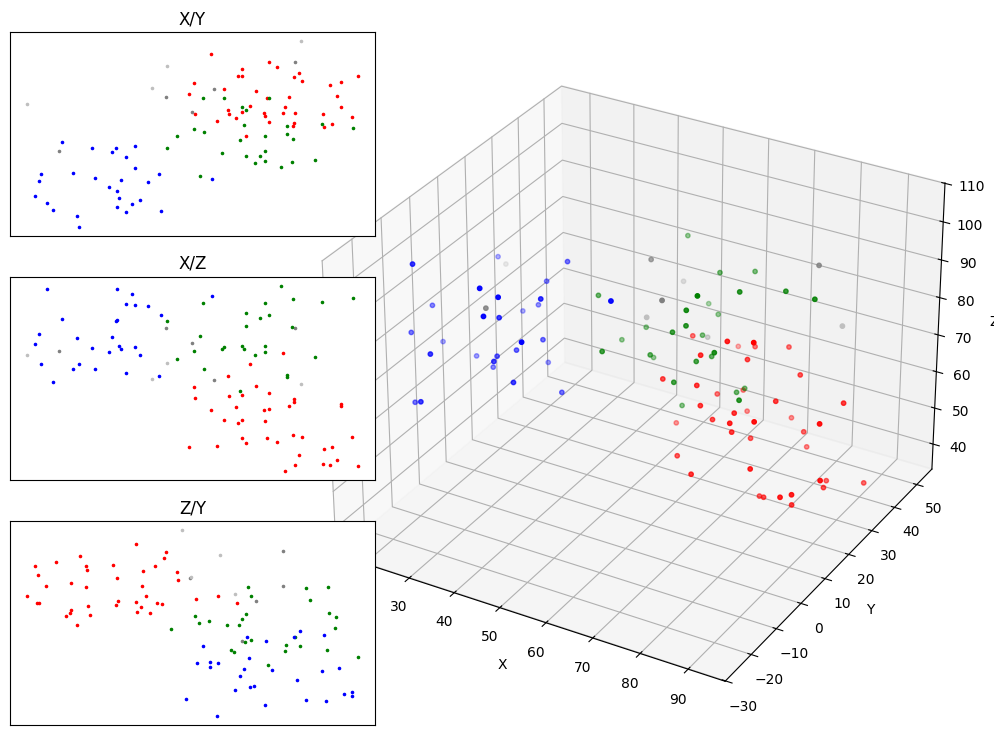

In [7]:
# Plot size of each chain
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import PDB

# Initialize figure and subplots
fig = plt.figure(figsize=(16, 9))
ax3d = fig.add_subplot(111, projection='3d')
ax_xy = fig.add_subplot(331)
ax_xy.set_title('X/Y')
ax_xz = fig.add_subplot(334)
ax_xz.set_title('X/Z')
ax_zy = fig.add_subplot(337)
ax_zy.set_title('Z/Y')

# Chain colors
color = {'A': 'r', 'B': 'g', 'C': 'b', 'E': '0.5', 'F': '0.75'}

# Zinc atom lists
zx, zy, zz = [], [], []

# Iterate over chains
for chain in p53_1tup.get_chains():
    xs, ys, zs = [], [], []
    
    # Iterate over residues (only every 10th for speed optimization)
    for i, residue in enumerate(chain.get_residues()):
        if i % 10 != 0:  # Skip some residues to speed up plotting
            continue

        # Select reference atom (CA for proteins)
        if "CA" in residue:
            ref_atom = residue["CA"]
        elif len(residue) > 0:
            ref_atom = list(residue.get_atoms())[0]  # Fallback: first available atom
        else:
            continue

        x, y, z = ref_atom.coord

        # Handle Zinc atoms separately
        if ref_atom.element == 'ZN':
            zx.append(x)
            zy.append(y)
            zz.append(z)
            continue

        xs.append(x)
        ys.append(y)
        zs.append(z)

    # Scatter plot for the chain
    if chain.id in color:  # Ensure the chain exists in the color dictionary
        ax3d.scatter(xs, ys, zs, color=color[chain.id], s=10)
        ax_xy.scatter(xs, ys, marker='.', color=color[chain.id], s=10)
        ax_xz.scatter(xs, zs, marker='.', color=color[chain.id], s=10)
        ax_zy.scatter(zs, ys, marker='.', color=color[chain.id], s=10)

# Set axis labels
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')

# Plot Zinc atoms (if any)
if zx:
    ax3d.scatter(zx, zy, zz, color='k', marker='v', s=80)
    ax_xy.scatter(zx, zy, color='k', marker='v', s=40)
    ax_xz.scatter(zx, zz, color='k', marker='v', s=40)
    ax_zy.scatter(zz, zy, color='k', marker='v', s=40)

# Hide axes for 2D projections
for ax in [ax_xy, ax_xz, ax_zy]:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

# Show the plot (non-blocking)
plt.show(block=False)


In [ ]:
## End of Notebook ##